In [54]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL

import os

In [55]:
load_dotenv()

True

In [56]:
openai_model=ChatOpenAI(model="gpt-4o-mini")

In [57]:
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [58]:
groq_model.invoke("hi")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 6, 'total_tokens': 22, 'completion_time': 0.058181818, 'prompt_time': 0.003481459, 'queue_time': 0.046268771, 'total_time': 0.061663277}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'stop', 'logprobs': None}, id='run-efd73082-6954-4b9c-af9a-29251ba7cf6c-0', usage_metadata={'input_tokens': 6, 'output_tokens': 16, 'total_tokens': 22})

In [59]:
openai_model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BRif8pLhOb4l2eYQzOeTKTl5k4ycA', 'finish_reason': 'stop', 'logprobs': None}, id='run-857cbb66-da37-457d-af5d-0b9f23c820b7-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [60]:
def add_numbers(state):
    result=state["num1"]+state["num2"]
    print(f"additional result: {result}")
    return Command(goto="multiply",update={"sum":result})

In [61]:
state={"num1":1, "num2":2}

In [62]:
add_numbers(state)

additional result: 3


Command(update={'sum': 3}, goto='multiply')

In [63]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return 

In [64]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return 

In [65]:
model_with_tool=openai_model.bind_tools([transfer_to_multiplication_expert])

In [66]:
ai_message=model_with_tool.invoke("hi how are you?")

In [67]:
ai_message.tool_calls

[]

In [68]:
ai_message=model_with_tool.invoke("what's (3 + 5) * 12. Provide me the output")

In [69]:
ai_message.tool_calls

[{'name': 'transfer_to_multiplication_expert',
  'args': {},
  'id': 'call_Aatzg0YioKcFe9Xze5HQc6l5',
  'type': 'tool_call'}]

In [70]:
# def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    
#     system_prompt = (
#         "You are an addition expert, you can ask the multiplication expert for help with multiplication."
#         "Always do your portion of calculation before the handoff."
#     )
    
#     messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
#     ai_msg = openai_model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    
#     if len(ai_msg.tool_calls) > 0:
#         tool_call_id = ai_msg.tool_calls[-1]["id"]
#         tool_msg = {
#             "role": "tool",
#             "content": "Successfully transferred",
#             "tool_call_id": tool_call_id,
#         }
        
#         return Command(
#             goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
#         )
#     return {"messages": [ai_msg]}

In [71]:
def additional_expert(state: MessagesState) -> Command[Literal["multiplication_expert", "__end__"]]:
    
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = openai_model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    # Create a copy of the AI message in the format expected by the API
    ai_msg_dict = {
        "role": "assistant",
        "content": ai_msg.content
    }
    
    # If there are tool calls, add them to the message dict
    if hasattr(ai_msg, 'tool_calls') and len(ai_msg.tool_calls) > 0:
        ai_msg_dict["tool_calls"] = ai_msg.tool_calls
    
    # Handle all tool calls, not just the last one
    if hasattr(ai_msg, 'tool_calls') and len(ai_msg.tool_calls) > 0:
        # Create tool messages for all tool calls
        tool_msgs = []
        for tool_call in ai_msg.tool_calls:
            tool_call_id = tool_call["id"]
            tool_msg = {
                "role": "tool",
                "content": "Successfully transferred",
                "tool_call_id": tool_call_id,
            }
            tool_msgs.append(tool_msg)
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg_dict] + tool_msgs}
        )
    
    return {"messages": [ai_msg_dict]}

In [72]:
# def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    
#     system_prompt = (
#         "You are a multiplication expert, you can ask an addition expert for help with addition. "
#         "Always do your portion of calculation before the handoff."
#     )
    
#     messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
#     ai_msg = openai_model.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
#     if len(ai_msg.tool_calls) > 0:
#         tool_call_id = ai_msg.tool_calls[-1]["id"]
#         tool_msg = {
#             "role": "tool",
#             "content": "Successfully transferred",
#             "tool_call_id": tool_call_id,
#         }
#         return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
#     return {"messages": [ai_msg]}

In [73]:
def multiplication_expert(state: MessagesState) -> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = openai_model.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    # Create a copy of the AI message in the format expected by the API
    ai_msg_dict = {
        "role": "assistant",
        "content": ai_msg.content
    }
    
    # If there are tool calls, add them to the message dict
    if hasattr(ai_msg, 'tool_calls') and len(ai_msg.tool_calls) > 0:
        ai_msg_dict["tool_calls"] = ai_msg.tool_calls
    
    # Handle all tool calls, not just the last one
    if hasattr(ai_msg, 'tool_calls') and len(ai_msg.tool_calls) > 0:
        # Create tool messages for all tool calls
        tool_msgs = []
        for tool_call in ai_msg.tool_calls:
            tool_call_id = tool_call["id"]
            tool_msg = {
                "role": "tool",
                "content": "Successfully transferred",
                "tool_call_id": tool_call_id,
            }
            tool_msgs.append(tool_msg)
        
        return Command(
            goto="additional_expert", update={"messages": [ai_msg_dict] + tool_msgs}
        )
    
    return {"messages": [ai_msg_dict]}

In [74]:
graph=StateGraph(MessagesState)

In [75]:
graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)

In [76]:
graph.add_edge(START, "additional_expert")

In [77]:
app=graph.compile()

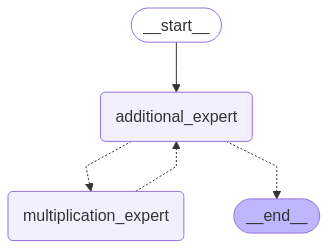

In [78]:
display(Image(app.get_graph().draw_mermaid_png()))

In [79]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='02212939-28fe-4407-aabb-17ca6b27d174'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, id='7845dcdc-3bc6-4c48-b313-7fdf57a5faca', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call_XeH8r4MfhEnoRPY0Uooy0MQ6', 'type': 'tool_call'}]),
  ToolMessage(content='Successfully transferred', id='7e596e1f-86d5-4194-a2bd-428b5d30e6c1', tool_call_id='call_XeH8r4MfhEnoRPY0Uooy0MQ6'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, id='5e2f8435-f7f5-4f80-a18e-0dc45438d3a7', tool_calls=[{'name': 'transfer_to_addition_expert', 'args': {}, 'id': 'call_tY63wqQzJdgqcFMiqPkDTz5G', 'type': 'tool_call'}, {'name': 'transfer_to_addition_expert', 'args': {}, 'id': 'call_xB8emq54TuhAVPj3MQHS1kuX', 'type': 'tool_call'}]),
  ToolMessage(content='Successfully transferred', id='910fc44a-a605-4a2d-be96-320ed30a6ebb', too

In [80]:
from langchain_core.messages import convert_to_messages
def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [52]:
# Let's run the graph with an expression that requires both addition and multiplication:
for chunk in app.stream(
    {"messages": [("user", "what's (3 + 5) * 12. Provide me the output")]},
):
    print("****chunk...****")
    
    pretty_print_messages(chunk)

****chunk...****
Update from node additional_expert:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_multiplication_expert (call_cdqZQBzfxa7xeFAPB127IlOB)
 Call ID: call_cdqZQBzfxa7xeFAPB127IlOB
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk...****
Update from node multiplication_expert:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_addition_expert (call_maQmTBvhf1xv0MCo7FABoVSp)
 Call ID: call_maQmTBvhf1xv0MCo7FABoVSp
  Args:
  transfer_to_addition_expert (call_N7bGhFtqSSny4O4GFdyx9jQ7)
 Call ID: call_N7bGhFtqSSny4O4GFdyx9jQ7
  Args:
================================= Tool Message =================================

Successfully transferred
================================= Tool Message =================================

Successfully transferred


****chunk...****
Update from node addit

In [81]:
@tool
def transfer_to_travel_advisor():
    """Ask travel advisor for help."""
    return
@tool
def transfer_to_hotel_advisor():
    """Ask hotel advisor for help."""
    return

In [82]:
def travel_advisor(state: MessagesState) -> Command[Literal["hotel_advisor", "__end__"]]:
    system_prompt = (
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = groq_model.bind_tools([transfer_to_hotel_advisor]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(goto="hotel_advisor", update={"messages": [ai_msg, tool_msg]})
    
    return {"messages": [ai_msg]}

In [83]:
def hotel_advisor(state: MessagesState) -> Command[Literal["travel_advisor", "__end__"]]:
    system_prompt = (
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = groq_model.bind_tools([transfer_to_travel_advisor]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="travel_advisor", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [84]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("travel_advisor", travel_advisor)
graph_builder.add_node("hotel_advisor", hotel_advisor)

In [85]:
# we'll always start with a general travel advisor
graph_builder.add_edge(START, "travel_advisor")

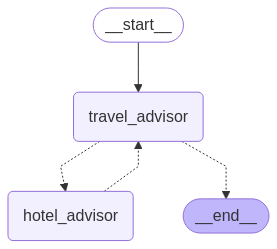

In [86]:
app = graph_builder.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [87]:
app.invoke({"messages":[("user","I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?")]})

{'messages': [HumanMessage(content='I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?', additional_kwargs={}, response_metadata={}, id='aeb2f4f4-f5b4-450c-9554-6036d6c7dffd'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gk4q', 'function': {'arguments': '{}', 'name': 'transfer_to_hotel_advisor'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 126, 'prompt_tokens': 178, 'total_tokens': 304, 'completion_time': 0.458181818, 'prompt_time': 0.016871978, 'queue_time': 37.731148779, 'total_time': 0.475053796}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-72919da3-96e3-4f2b-b86f-de4cd01da926-0', tool_calls=[{'name': 'transfer_to_hotel_advisor', 'args': {}, 'id': 'call_gk4q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 178, 'output_tokens': 126, 'total_to

In [88]:
for chunk in app.stream(
    {"messages": [("user", "I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?")]},
):
    print("****chunk****")
    
    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_hotel_advisor (call_be1b)
 Call ID: call_be1b
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node hotel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_travel_advisor (call_87hp)
 Call ID: call_87hp
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================

Sure! To assist you with your travel plans from Mumbai to California, I can provide information on flight options, travel tips, and things to do in California. For hotel recommendations, I'll transfer you to the hotel advisor. Let 

In [90]:
for chunk in app.stream(
    {"messages": [("user", "What are the best flight options from Mumbai to California, and can you recommend top hotels for a comfortable and convenient stay?")]},
):
    print("****chunk****")
    
    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_hotel_advisor (call_b7vp)
 Call ID: call_b7vp
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node hotel_advisor:


================================== Ai Message ==================================

Sure! For flight options from Mumbai to California, I recommend checking with major airlines like Air India, Emirates, Qatar Airways, or United Airlines for the best routes and deals. It's always a good idea to book in advance for better prices.

As for hotels, here are some top recommendations for a comfortable and convenient stay in California:

### Los Angeles:
1. **The Ritz-Carlton, Los Angeles** - Luxurious and centrally located, perfect for both leisure and business travelers.
2. **The Beverly Hills Hotel** - Iconic and elegant, offering a